# Ottimizzazione Data Analytics

Una panoramica delle librerie per la manipolazione dati in Python

In [ ]:
# Setup delle dipendenze (eseguire solo se necessario)
# !pip install pyarrow pandas polars

## Pandas: Il Data Frame Standard

**Pandas** è diventato lo standard de facto per la manipolazione dei dati in Python, offrendo:

- Una sintassi intuitiva per la manipolazione di tabelle
- Funzioni per caricamento e salvataggio dati da vari formati
- Strumenti per pulizia, trasformazione e analisi dei dati
- Integrazione profonda con l'ecosistema scientifico Python

## I Limiti di Pandas

Con l'aumento delle dimensioni dei dati, Pandas presenta diverse limitazioni:

1. **Prestazioni**: implementato in Python/C, con overhead legato al GIL
2. **Memoria**: carica l'intero dataset in RAM
3. **Parallelismo**: limitato supporto per elaborazione parallela
4. **Tipo Dati**: gestione inefficiente di alcuni tipi (es. stringhe, liste)
5. **Scalabilità**: difficoltà con dataset che superano la RAM disponibile

## Alternative a Pandas

Diverse librerie sono state sviluppate per superare i limiti di Pandas:

**Polars**: libreria per DataFrame scritta in Rust, basata su Apache Arrow
- Performance nettamente superiori
- Elaborazione in parallelo di default
- Valutazione pigra (lazy evaluation) per ottimizzazione automatica
- API simile a Pandas ma più moderna

**Dask**: estende Pandas e NumPy parallelizzando operazioni su cluster
- API quasi identica a Pandas (facile transizione)
- Elaborazione distribuita
- Gestione di dataset più grandi della memoria disponibile
- Integrazione con l'ecosistema scientifico

**cuDF (RAPIDS)**: implementazione GPU-accelerated di Pandas
- Accelerazione tramite GPU NVIDIA
- API simile a Pandas
- Integrabile con ecosistema RAPIDS per machine learning su GPU

**DuckDB**: motore di database analitico per DataFrame in-process
- Esecuzione di query SQL su DataFrame
- Performance fino a 10-100x più veloci di SQLite
- Ottimizzato per analisi OLAP
- Perfetta integrazione con Pandas e Apache Arrow

## Ottimizzare Pandas

Prima di passare ad alternative, si può migliorare Pandas con alcune tecniche:

1. **Caricamento selettivo**: usare `usecols` per leggere solo le colonne necessarie
2. **Tipi di dato ottimali**: specificare `dtype` o usare `pd.Categorical` per dati categorici
3. **Chunking**: processare dati in blocchi con `chunksize`
4. **PyArrow**: utilizzare `engine='pyarrow'` per lettura/scrittura più veloce
5. **Vettorializzare**: preferire operazioni vettoriali invece di loop Python
6. **Query**: usare `df.query()` per espressioni complesse

In [1]:
import pandas as pd

# Configurazione per la visualizzazione
pd.set_option('display.max_rows', 6)
pd.set_option("max_colwidth", 15)

In [3]:
# Esempio di caricamento ottimizzato
# 1. Uso di usecols per selezionare solo colonne specifiche
# 2. Uso di dtype per specificare tipi esatti
# 3. Uso di engine='pyarrow' per prestazioni migliori

colonne = ['B', 'C']
tipi = {'B': 'int32', 'C': 'string'}

# Commentato per evitare l'esecuzione che consuma tempo
pd.read_csv('data.csv', 
            usecols=colonne, 
            dtype=tipi, 
            engine='pyarrow')

,B,C
0,2,a
1,3,b
2,4,c
...,...,...
5,7,f
6,8,g
7,9,h


In [ ]:
# Esempio di caricamento con chunk per gestire dataset grandi

result_df = []
for i, chunk in enumerate(pd.read_csv("data.csv", chunksize=2)):
    print(f"Lunghezza del chunk # {i}: {len(chunk)}")
    chunk['A'] = chunk['A'].mean()
    
    result_df.append(chunk)
pd.concat(result_df, ignore_index=True)  # Unione dei chunk filtrati

# Focus su Polars

Approfondiamo ora **Polars**, una delle alternative più promettenti a Pandas:

In [4]:
import polars as pl

# Configurazione per la visualizzazione
pl.Config().set_tbl_rows(6)

polars.config.Config

## Pandas vs Polars

| **Pandas** | **Polars** |
|------------|------------|
| Indice Row-oriented | Column-oriented (Apache Arrow) |
| Operazioni in-place | Operazioni immutabili (funzionale) |
| GIL Python limita parallelismo | Computazioni parallele in Rust |
| NA, None, NaN, ecc. | Concetto unificato di null |

## Creazione e I/O in Polars vs Pandas

In [5]:
# Creazione DataFrame in Pandas
pandas_df = pd.DataFrame({
    'A': [1, 2, 3, 4, 5],
    'B': [10, 20, 30, 40, 50],
    'C': ['a', 'b', 'c', 'd', 'e']
})

pandas_df

,A,B,C
0,1,10,a
1,2,20,b
2,3,30,c
3,4,40,d
4,5,50,e


In [6]:
# Creazione DataFrame in Polars
polars_df = pl.DataFrame({
    'A': [1, 2, 3, 4, 5],
    'B': [10, 20, 30, 40, 50],
    'C': ['a', 'b', 'c', 'd', 'e']
})

polars_df

A,B,C
i64,i64,str
1,10,"""a"""
2,20,"""b"""
3,30,"""c"""
4,40,"""d"""
5,50,"""e"""


In [8]:
# Tipi dati in Pandas vs Polars
print("Pandas dtypes:")
print(pandas_df.dtypes)
print("\nPolars dtypes:")
print(polars_df.dtypes)

Pandas dtypes:
A     int64
B     int64
C    object
dtype: object

Polars dtypes:
[Int64, Int64, String]


In [9]:
# I/O confronto: sintassi equivalente ma internamente molto diversa

# Pandas
pandas_df.to_csv("data.csv")
df_pandas = pd.read_csv("data.csv")

# Polars
polars_df.write_csv("data.csv")
df_polars = pl.read_csv("data.csv")

In [10]:
# Con Polars si può usare anche l'API Lazy
df_lazy = pl.scan_csv("data.csv")
df_lazy

## Principali Differenze: Context e Expressions

Polars introduce due concetti fondamentali per manipolare i dati:

1. **Context**: in quale contesto un'espressione viene valutata
2. **Expressions**: operazioni su colonne definite tramite API fluida

### I Tre Context di Polars:

1. **Selection**: `df.select(...)` e `df.with_columns(...)`
2. **Filtering**: `df.filter(...)`
3. **Aggregation**: `df.group_by(...).agg(...)`

Ogni contesto interpreta le expressions in modo diverso.

## Pandas vs Polars: Selezione Colonne

In [11]:
# Pandas: selezione colonne
pandas_df[['A', 'B']]  # Sintassi classica
# Alternativa: pandas_df.loc[:, ['A', 'B']]

,A,B
0,1,10
1,2,20
2,3,30
3,4,40
4,5,50


In [13]:
# Polars: selezione colonne
polars_df.select(['A', 'B'])  # Sintassi esplicita
# polars_df.select(pl.col(['A', 'B']))

A,B
i64,i64
1,10
2,20
3,30
4,40
5,50


## Pandas vs Polars: Trasformazione Colonne

In [14]:
# Pandas: aggiungere/modificare colonne
pandas_df_mod = pandas_df.copy()
pandas_df_mod['D'] = pandas_df_mod['A'] * 100  # Nuova colonna
pandas_df_mod['B'] = pandas_df_mod['B'] + 5    # Modifica colonna esistente
pandas_df_mod

,A,B,C,D
0,1,15,a,100
1,2,25,b,200
2,3,35,c,300
3,4,45,d,400
4,5,55,e,500


In [15]:
# Polars: aggiungere/modificare colonne
polars_df.with_columns([
    pl.col("A") * 100,         # Sovrascrive "A"
    (pl.col("B") + 5).alias("B"),  # Sovrascrive "B"
    pl.col("A").mul(100).alias("D")  # Nuova colonna
])

A,B,C,D
i64,i64,str,i64
100,15,"""a""",100
200,25,"""b""",200
300,35,"""c""",300
400,45,"""d""",400
500,55,"""e""",500


## Pandas vs Polars: Filtri

In [16]:
# Pandas: filtri con operatori booleani
pandas_df[(pandas_df['A'] > 2) & (pandas_df['B'] <= 40)]
# Alternativa: pandas_df.query("A > 2 & B <= 40")

,A,B,C
2,3,30,c
3,4,40,d


In [17]:
# Polars: filtri con context dedicato
polars_df.filter(
    (pl.col("A") > 2) & (pl.col("B") <= 40)
)

A,B,C
i64,i64,str
3,30,"""c"""
4,40,"""d"""


## Pandas vs Polars: Aggregazioni

In [18]:
# Dati più adatti per gruppi
df_agg = pd.DataFrame({
    'gruppo': ['A', 'A', 'A', 'B', 'B', 'C'],
    'valore1': [10, 20, 15, 30, 25, 40],
    'valore2': [100, 110, 120, 200, 210, 300]
})

df_agg

,gruppo,valore1,valore2
0,A,10,100
1,A,20,110
2,A,15,120
3,B,30,200
4,B,25,210
5,C,40,300


In [19]:
# Pandas: aggregazione con groupby
df_agg.groupby('gruppo').agg({
    'valore1': ['sum', 'mean'],
    'valore2': ['min', 'max']
})

valore1       valore2     
           sum  mean     min  max
gruppo                           
A           45  15.0     100  120
B           55  27.5     200  210
C           40  40.0     300  300

In [20]:
# Polars: stesso dataset
pl_agg = pl.from_pandas(df_agg)

# Aggregazione con context dedicato
pl_agg.group_by('gruppo').agg([
    pl.col('valore1').sum().alias('valore1_sum'),
    pl.col('valore1').mean().alias('valore1_mean'),
    pl.col('valore2').min().alias('valore2_min'),
    pl.col('valore2').max().alias('valore2_max')
])

gruppo,valore1_sum,valore1_mean,valore2_min,valore2_max
str,i64,f64,i64,i64
"""B""",55,27.5,200,210
"""C""",40,40.0,300,300
"""A""",45,15.0,100,120


## Vantaggi Esclusivi di Polars

### 1. Gestione Nativa delle Liste (No Object dtype)

Pandas rappresenta liste come Python objects, causando inefficienze. Polars ha supporto nativo.

In [21]:
# Liste in Polars
pl.DataFrame({
    'ID': [1, 2, 3],
    'valori': [[1,2,3], [4,5], [6,7,8,9]]
})

ID,valori
i64,list[i64]
1,"[1, 2, 3]"
2,"[4, 5]"
3,"[6, 7, … 9]"


In [22]:
# Operazioni su liste
df_list = pl.DataFrame({
    'ID': [1, 2, 3],
    'valori': [[1,2,3], [4,5], [6,7,8,9]]
})

df_list.with_columns([
    pl.col('valori').list.len().alias('lunghezza'),
    pl.col('valori').list.sum().alias('somma')
])

ID,valori,lunghezza,somma
i64,list[i64],u32,i64
1,"[1, 2, 3]",3,6
2,"[4, 5]",2,9
3,"[6, 7, … 9]",4,30


### 2. Lazy Evaluation

In [23]:
# Polars: Lazy API con ottimizzazione automatica
lazy_query = (
    pl_agg.lazy()
    .filter(pl.col('valore1') > 15)
    .group_by('gruppo')
    .agg([
        pl.col('valore1').sum().alias('valore1_sum'),
        pl.col('valore2').mean().alias('valore2_mean')
    ])
    .sort('valore1_sum', descending=True)
)

# Visualizza il piano di query invece di eseguirlo
lazy_query

In [24]:
# Esecuzione della query ottimizzata
lazy_query.collect()

gruppo,valore1_sum,valore2_mean
str,i64,f64
"""B""",55,205.0
"""C""",40,300.0
"""A""",20,110.0


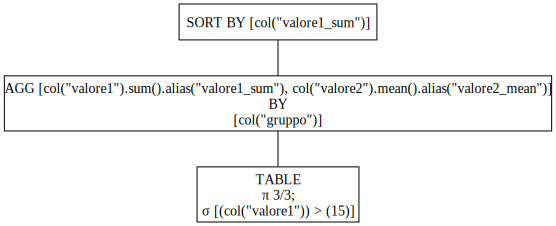

In [25]:
# Visualizzazione grafica del piano di esecuzione
lazy_query.show_graph()

### 3. Operazioni Orizzontali e Folds

In [26]:
import polars.selectors as cs

# Aggregazione orizzontale di valori
pl_agg.select(
    pl.sum_horizontal(cs.numeric()).alias("somma_orizzontale")
)

somma_orizzontale
i64
110
130
135
230
235
340


In [27]:
# Fold (riduzione personalizzata)
pl_agg.select(
    pl.fold(
        acc=pl.lit(1),
        function=lambda acc, x: acc * x,
        exprs=pl.col(['valore1', 'valore2'])
    ).alias('prodotto_valori')
)

prodotto_valori
i64
1000
2200
1800
6000
5250
12000


## Pandas vs Polars: Join

In [28]:
customers = pd.DataFrame({
    'customer_id': [1, 2, 3, 4, 5],
    'name': ['Alice', 'Bob', 'Carol', 'Dave', 'Eve']
})

orders = pd.DataFrame({
    'order_id': [101, 102, 103, 104, 105],
    'customer_id': [3, 1, 5, 2, 1],
    'amount': [50, 25, 75, 40, 15]
})

# Pandas join (usando merge)
pd_joined = customers.merge(
    orders, 
    on='customer_id', 
    how='inner'
)

pd_joined

,customer_id,name,order_id,amount
0,1,Alice,102,25
1,1,Alice,105,15
2,2,Bob,104,40
3,3,Carol,101,50
4,5,Eve,103,75


In [30]:
pl_customers = pl.from_pandas(customers)

pl_orders = pl.from_pandas(orders)

# Join in Polars (più esplicito)
pl_joined = pl_customers.join(
    pl_orders,
    on='customer_id',
    how='anti'
)

pl_joined

customer_id,name
i64,str
4,"""Dave"""


## Pandas vs Polars: Gestione Stringhe

In [31]:
# DataFrame con stringhe
text_df = pd.DataFrame({
    'id': [1, 2, 3, 4],
    'text': ['hello world', 'data science', 'pandas vs polars', 'python is great']
})

# Manipolazione stringhe in Pandas
text_df['uppercase'] = text_df['text'].str.upper()
text_df['words'] = text_df['text'].str.split()
text_df['word_count'] = text_df['text'].str.count(' ') + 1

text_df

,id,text,uppercase,words,word_count
0,1,hello world,HELLO WORLD,"[hello, world]",2
1,2,data science,DATA SCIENCE,"[data, scie...",2
2,3,pandas vs p...,PANDAS VS P...,"[pandas, vs...",3
3,4,python is g...,PYTHON IS G...,"[python, is...",3


In [32]:
# DataFrame equivalente in Polars
pl_text = pl.DataFrame({
    'id': [1, 2, 3, 4],
    'text': ['hello world', 'data science', 'pandas vs polars', 'python is great']
})

# Manipolazione stringhe in Polars
pl_text.with_columns([
    pl.col('text').str.to_uppercase().alias('uppercase'),
    pl.col('text').str.split(' ').alias('words'),
    (pl.col('text').str.count_matches(' ') + 1).alias('word_count')
])

id,text,uppercase,words,word_count
i64,str,str,list[str],u32
1,"""hello world""","""HELLO WORLD""","[""hello"", ""world""]",2
2,"""data science""","""DATA SCIENCE""","[""data"", ""science""]",2
3,"""pandas vs polars""","""PANDAS VS POLARS""","[""pandas"", ""vs"", ""polars""]",3
4,"""python is great""","""PYTHON IS GREAT""","[""python"", ""is"", ""great""]",3


## Pipeline di Trasformazioni

In [33]:
# Esempio di pipeline in Pandas
pd_result = (
    df_agg
    .query('valore1 > 15')
    .groupby('gruppo')
    .agg(
        valore1_sum=('valore1', 'sum'),
        valore2_mean=('valore2', 'mean')
    )
    .sort_values('valore1_sum', ascending=False)
    .reset_index()
)

pd_result

,gruppo,valore1_sum,valore2_mean
0,B,55,205.0
1,C,40,300.0
2,A,20,110.0


In [34]:
# Esempio di pipeline in Polars (API Eager)
pl_result = (
    pl_agg
    .filter(pl.col('valore1') > 15)
    .group_by('gruppo')
    .agg([
        pl.col('valore1').sum().alias('valore1_sum'),
        pl.col('valore2').mean().alias('valore2_mean')
    ])
    .sort('valore1_sum', descending=True)
)

pl_result

gruppo,valore1_sum,valore2_mean
str,i64,f64
"""B""",55,205.0
"""C""",40,300.0
"""A""",20,110.0
